Required packages

In [1]:
!pip install torch_geometric
%matplotlib inline


import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking # change here ,to segregate the training and test sets
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv

import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=a73eec13f3343750a95671b446543ecc687e9dbd59ae2db50db76b526e72223c
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


 Dataset exploration

In [2]:
with open("/content/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)
edges=pd.read_csv("/content/musae_git_edges.csv")
target_df=pd.read_csv("/content/musae_git_target.csv")

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [3]:
import seaborn as sns

[Text(0.5, 1.0, 'Classes Count')]

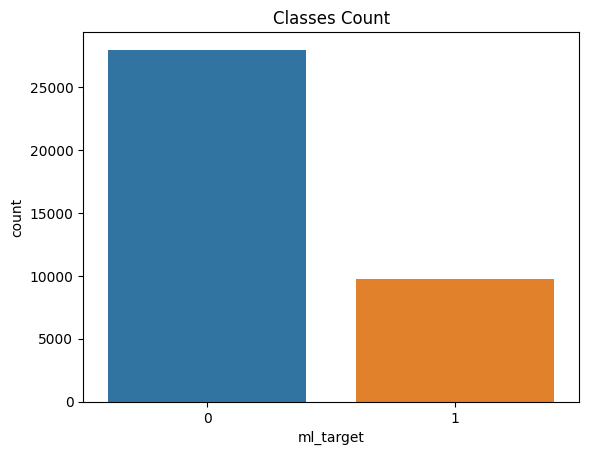

In [4]:
sns.countplot(x='ml_target',data=target_df).set(title='Classes Count')

In [72]:

feats=[]  
feat_counts=[]  
for i in range(len(data_raw)):  
    feat_counts+=[len(data_raw[str(i)])]  
    feats+=data_raw[str(i)]


Features encoding

In [4]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)

    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)

    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

In [7]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)

Graph construction and visualization

In [5]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [6]:
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return

    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

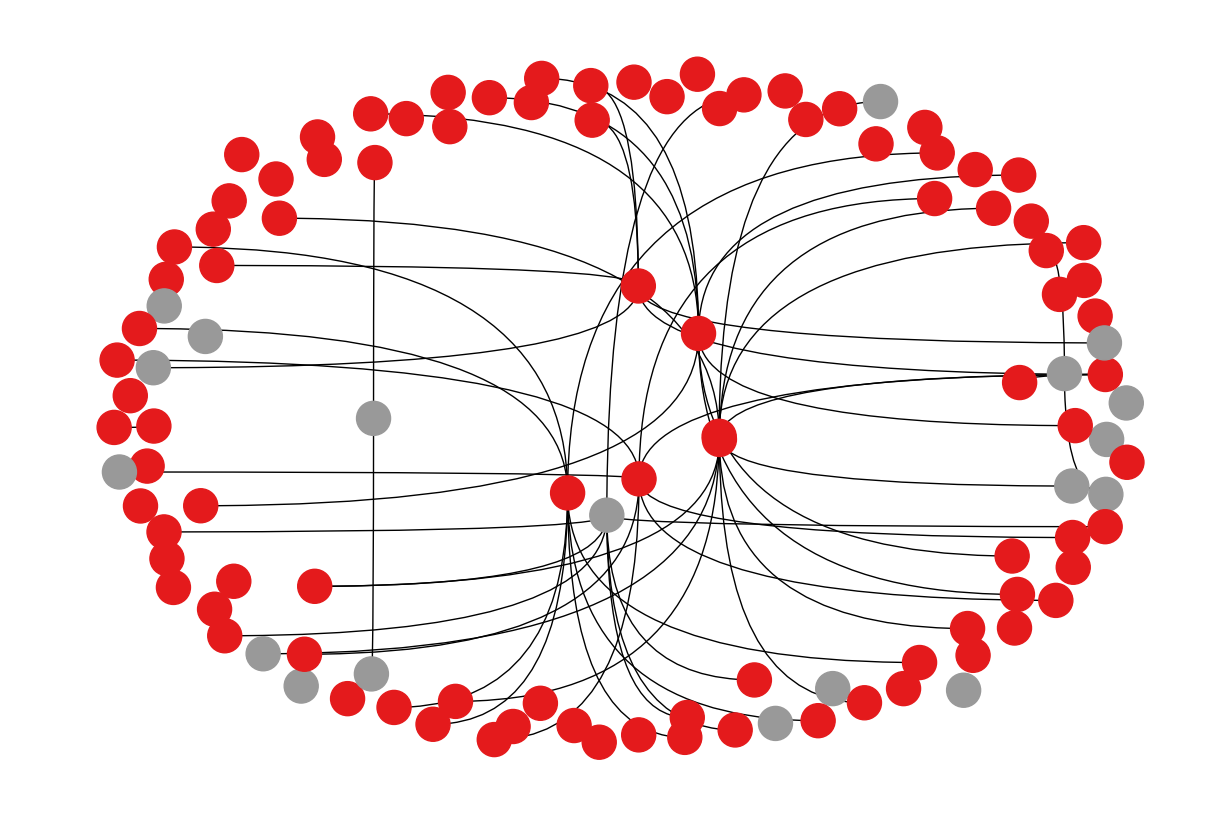

In [10]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)


Construct and train our GNN model

In [7]:
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)

In [8]:
print(g.num_features)

4005


In [9]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

training samples 3770
validation samples 11310
test samples 22620


In [67]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    

def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)

In [64]:
class GCN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)

    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [62]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(g.num_features, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 8, 2, heads=1, dropout=0.6)

    def forward(self,data):
        x = data.x.float()
        edge_index =  data.edge_index
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [73]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    net.train()

    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]

    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss.detach().numpy()]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss.detach().numpy()]

        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy.detach().numpy()]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy.detach().numpy()]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

    plt.title('Loss')
    plt.plot(train_losses)  
    plt.plot(val_losses)
    plt.plot(test_losses)  
    plt.show()
    
    plt.title('Accuracy')
    plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    plt.plot(test_accuracies) 
    plt.show()

   


   # x = [test_accuracies, train_accuracies, test_losses, train_losses]
    #plt.hist(x, bins=2)
    #plt.show()  

Epoch 1/50, Train_Loss: 0.6896, Train_Accuracy: 0.6531, Val_Accuracy: 0.6443, Test_Accuracy: 0.6534
Epoch 2/50, Train_Loss: 0.9248, Train_Accuracy: 0.7584, Val_Accuracy: 0.7418, Test_Accuracy: 0.7391
Epoch 3/50, Train_Loss: 0.4480, Train_Accuracy: 0.8706, Val_Accuracy: 0.8606, Test_Accuracy: 0.8574
Epoch 10/50, Train_Loss: 0.3530, Train_Accuracy: 0.8790, Val_Accuracy: 0.8656, Test_Accuracy: 0.8640
Epoch 13/50, Train_Loss: 0.3399, Train_Accuracy: 0.8798, Val_Accuracy: 0.8686, Test_Accuracy: 0.8641
Epoch 14/50, Train_Loss: 0.3315, Train_Accuracy: 0.8777, Val_Accuracy: 0.8695, Test_Accuracy: 0.8644
Epoch 19/50, Train_Loss: 0.3281, Train_Accuracy: 0.8796, Val_Accuracy: 0.8708, Test_Accuracy: 0.8638
Epoch 20/50, Train_Loss: 0.3245, Train_Accuracy: 0.8820, Val_Accuracy: 0.8718, Test_Accuracy: 0.8657
Epoch 21/50, Train_Loss: 0.3244, Train_Accuracy: 0.8806, Val_Accuracy: 0.8721, Test_Accuracy: 0.8678
Epoch 25/50, Train_Loss: 0.3194, Train_Accuracy: 0.8828, Val_Accuracy: 0.8729, Test_Accuracy: 

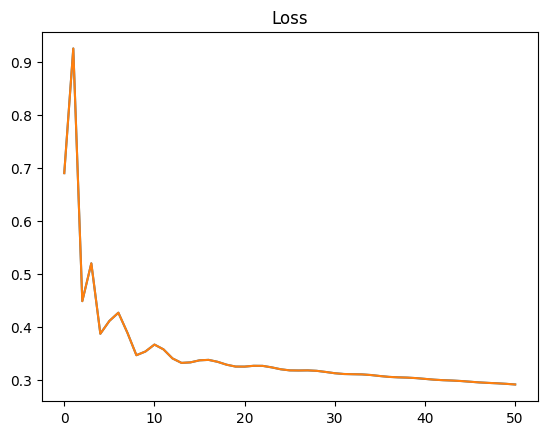

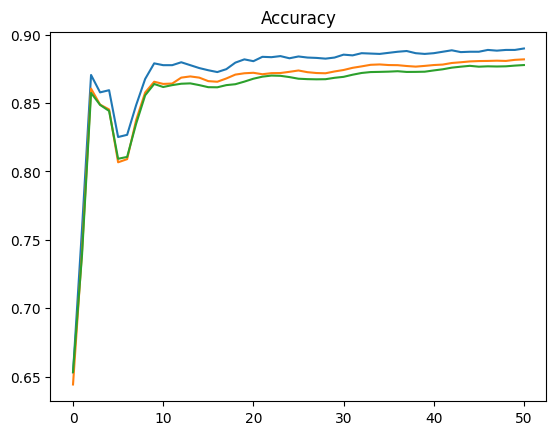

In [68]:
gcn_model=GCN(num_of_feat=g.num_node_features,f=16)
criterion=nn.CrossEntropyLoss()
train_social(gcn_model,g,epochs=50,lr=0.1)

Epoch 1/50, Train_Loss: 0.7005, Train_Accuracy: 0.3188, Val_Accuracy: 0.3432, Test_Accuracy: 0.3529
Epoch 2/50, Train_Loss: 4.2265, Train_Accuracy: 0.7581, Val_Accuracy: 0.7417, Test_Accuracy: 0.7389
Epoch 3/50, Train_Loss: 0.7846, Train_Accuracy: 0.7690, Val_Accuracy: 0.7505, Test_Accuracy: 0.7488
Epoch 6/50, Train_Loss: 0.4765, Train_Accuracy: 0.7881, Val_Accuracy: 0.7677, Test_Accuracy: 0.7637
Epoch 8/50, Train_Loss: 0.5788, Train_Accuracy: 0.7782, Val_Accuracy: 0.7694, Test_Accuracy: 0.7638
Epoch 9/50, Train_Loss: 0.5070, Train_Accuracy: 0.8162, Val_Accuracy: 0.8079, Test_Accuracy: 0.8005
Epoch 11/50, Train_Loss: 0.4456, Train_Accuracy: 0.8236, Val_Accuracy: 0.8102, Test_Accuracy: 0.8100
Epoch 17/50, Train_Loss: 0.4468, Train_Accuracy: 0.8141, Val_Accuracy: 0.8106, Test_Accuracy: 0.8057
Epoch 21/50, Train_Loss: 0.4288, Train_Accuracy: 0.8223, Val_Accuracy: 0.8107, Test_Accuracy: 0.8054
Epoch 22/50, Train_Loss: 0.4191, Train_Accuracy: 0.8244, Val_Accuracy: 0.8179, Test_Accuracy: 0.8

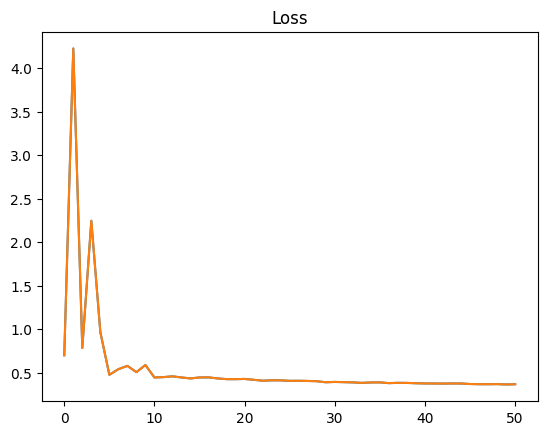

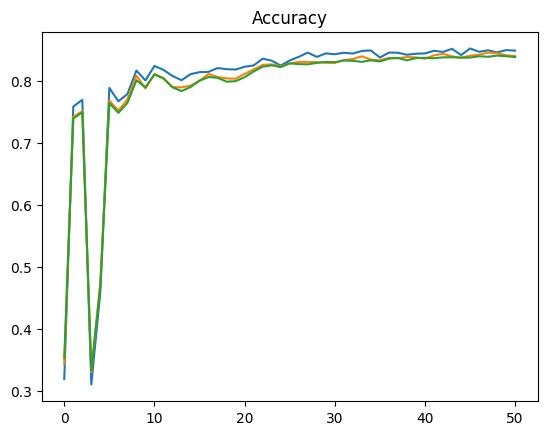

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gat_model = GAT(hidden_channels=8)#.to(device)
criterion=nn.CrossEntropyLoss()
train_social(gat_model,g,epochs=50,lr=0.1)